# 简单理解 RHF 含频极化率及其与 TD-HF 间的关系

含频极化率在非线性光学中有所应用。这里指的频率是入射激发光频率，而非分子振动频率。含频极化率英文是 Frequency-Dependent Polarizability，也有时使用动态 Dynamic 替代含频 Frequency-Dependent；相对地，没有入射激发光给出的极化率称为静态 Static 极化率。

但这也只是道听途说。对于我来讲更直接的意义会是，含频极化率对坐标的一阶导数可以用于计算含频 Raman 光谱。

写这篇文档一开始的原因是，曾经在尝试计算简单的 SERS 光谱时，发现 [文献](https://dx.doi.org/10.1021/jz4012383) 的含频 Raman 光谱计算的文章提到使用 TD-DFT (time-dependent density functional theory)；其它文献也几乎无一例外。这多少对我来说有点意外。Raman 光谱的计算通过求取极化率对简正坐标的导数 (不管是解析的还是数值的) 得到，而极化率则可以通过 CP-HF (coupled-perturbated Hartree-Fock) 方程给出。此前我确实地成功得到了 Gaussian 所给出的 RKS (GGA level) 极化率，并且并没有使用 TD-DFT 计算，而是 CP-KS (coupled-perturbated Kohn-Sham) 方程计算得到的极化率；我曾经一度以为这是 ADF 软件与 Gaussian 软件两者的区别。后来在各路同学的提醒下，才渐渐明白极化率与含时分析 (TD) 之间的关系。

这篇文档将会忽略大部分与公式推导有关的问题；这是由于 TD-DFT 或 TD-HF 的公式推导并不简单；在短时间之内我重复不出让我自己信服的推导。这篇文档不讨论与复数有关的话题，变量与公式全部采用实数与实函数。

我们会使用非对称的双氧水分子作为演示分子，基组使用 6-31G。计算程序使用 PySCF 提供电子积分，并与 Gaussian 的含频极化率、PySCF 的激发频率计算结果作对应。

In [1]:
%matplotlib notebook

import numpy as np
import scipy
from pyscf import gto, scf, tdscf
from functools import partial
import matplotlib.pyplot as plt
from matplotlib import patches
from formchk_interface import FormchkInterface

np.einsum = partial(np.einsum, optimize=["greedy", 1024 ** 3 * 2 / 8])
np.set_printoptions(5, linewidth=150, suppress=True)

全文使用以下记号：

- $p, q, r, s, m$ 表示全部轨道

- $i, j$ 表示占据分子轨道

- $a, b$ 表示非占分子轨道

- $\mu, \nu, \kappa, \lambda$ 表示原子轨道

- $t, s$ 在不引起歧义的情况下表示空间取向 $x, y, z$

- $P, Q, R, S$ 在这篇文档表示类似于 $ai$ 的组合下标

- $n$ 表示 TD-HF 激发态

全文使用简化与不严格的 Einstein Summation Convention。

下面补充一个原子单位能量 $E_\mathrm{h}$ 到波数 $\mathrm{cm}^{-1}$ 的换算 `Eh_cm`：

$$
1 \, E_\mathrm{h} = 219474.6 \, \mathrm{cm}^{-1}
$$

In [2]:
from scipy.constants import physical_constants
Eh_cm = physical_constants["hartree-inverse meter relationship"][0] / 100
Eh_cm

219474.6313702

## 分子体系与标准结果

<div class="alert alert-info">

**阅读提示**

我们会花很长的时间进行分子体系与标准结果的定义。如果对代码与文本阅读能力有信心，这段可以跳过。

</div>

### PySCF 体系定义

在进入下面的讨论前，我们先定义如下变量：

- `mol` PySCF 分子实例

In [3]:
mol = gto.Mole()
mol.atom = """
O  0.0  0.0  0.0
O  0.0  0.0  1.5
H  1.0  0.0  0.0
H  0.0  0.7  1.0
"""
mol.basis = "6-31G"
mol.verbose = 0
mol.build()

- `nao` 轨道数量 $n_\mathrm{AO}$, `nocc` 占据轨道数 $n_\mathrm{occ}$, `nvir` 非占轨道数 $n_\mathrm{vir}$

- `so` 占据轨道分割，`sv` 非占轨道分割，`sa` 全轨道分割

- `eri0_ao` 原子轨道基组双电子积分 ERI (electron repulsion integral)

    $$
    (\mu \nu | \kappa \lambda) = \int \phi_\mu (\boldsymbol{r}) \phi_\nu (\boldsymbol{r}) \frac{1}{|\boldsymbol{r} - \boldsymbol{r}'|} \phi_\kappa (\boldsymbol{r}') \phi_\lambda (\boldsymbol{r}') \, \mathrm{d} \boldsymbol{r} \, \mathrm{d} \boldsymbol{r}'
    $$

- `d_ao` 偶极积分，其中下述的 $t$ 或后文会出现的 $s$ 表示偶极积分的方向 $x, y$ 或 $z$

    $$
    d_{\mu \nu}^t = - \langle \mu | t | \nu \rangle = \int \phi_\mu (\boldsymbol{r}) t \phi_\nu (\boldsymbol{r}) \, \mathrm{d} \boldsymbol{r}
    $$

In [4]:
nao = nmo = mol.nao
nocc = mol.nelec[0]
nvir = nmo - nocc
so, sv, sa = slice(0, nocc), slice(nocc, nmo), slice(0, nmo)

In [5]:
eri0_ao = mol.intor("int2e")
d_ao = - mol.intor("int1e_r")

- `scf_eng` PySCF 的 RHF 计算实例

In [6]:
scf_eng = scf.RHF(mol).run()

- `C` $C_{\mu p}$ 分子轨道系数

- `e` $e_p$ RHF 轨道能量

- `D` $D_{\mu \nu} = 2 C_{\mu i} C_{\nu i}$ RHF 电子态密度

In [7]:
C, e = scf_eng.mo_coeff, scf_eng.mo_energy
D = 2 * C[:, so] @ C[:, so].T

- `eri0_mo` 分子轨道双电子 ERI $(pq|rs) = C_{\mu p} C_{\nu q} (\mu \nu | \kappa \lambda) C_{\kappa r} C_{\lambda s}$

- `d_mo` 分子轨道偶极积分 $d^t_{pq} = C_{\mu p} d^t_{\mu \nu} C_{\nu q}$

- `d_ia` 占据-非占的分子轨道偶极积分 $d^t_{ia}$

- `d_P` 以双下标 $P = ia$ 为记号的占据-非占分子轨道偶极积分 $d^t_P$

In [8]:
eri0_mo = np.einsum("up, vq, uvkl, kr, ls -> pqrs", C, C, eri0_ao, C, C)
d_mo = np.einsum("up, tuv, vq -> tpq", C, d_ao, C)
d_ia = d_mo[:, so, sv]
d_P = d_ia.reshape(3, nocc*nvir)

- `scf_td` PySCF 的 TD-RHF 计算实例

In [9]:
scf_td = tdscf.TDHF(scf_eng)
scf_td.nstates = nvir * nocc
scf_td.run()

就我目前所知，PySCF 可以计算极化率；但与含频极化率有关的计算，我在这里采用下文所述的、与 Gaussian 可以大致匹配结果的程序。

### Gaussian 计算含频极化率

我们需要一个可以核验结果的结果与工具。Gaussian 事实上提供了含频的极化率的选项。这一小段我们简单了解如何使用 Gaussian 来计算含频极化率。

我们首先给给出一个示范的例子。这个例子只是演示，并不能代表真实的物理。

Gaussian 的 [输入卡](assets/H2O2_freq_polar_example.gjf) 如下：

In [10]:
with open("assets/H2O2_freq_polar_example.gjf", "r") as f:
    print(f.read()[:-1])

%chk=H2O2_freq_polar_example.chk
# RHF/6-31G NoSymm Freq(Raman) CPHF=RdFreq

H2O2 Frequency-Dependent Polarizability (Raman)

0 1
O  0.0  0.0  0.0
O  0.0  0.0  1.5
H  1.0  0.0  0.0
H  0.0  0.7  1.0

1nm


事实上这段程序不只计算了含频极化率，还计算了含频 Raman；但这份文档只讨论极化率问题。这里的“含频”指的是两个频率，其一为静态 (static) 极化率，其二是入射光线为 $\omega = 1 \, \mathrm{nm}$ 频率下的极化率。后者是一个相当极端的例子，因为通常可能没有人会想到用 X-Ray 照射一个普通的液体分子。

Gaussian 程序默认会输出 .out 或 .log 文件作为文本信息输出，其输出文件在 [H2O2_freq_polar_example.out](assets/H2O2_freq_polar_example.out) 中。我们还要求 Gaussian 输出 .chk 文件，该文件只包含单纯的计算数据信息，其通过 Gaussian Utility `formchk` 导出为 ASCII 格式的文件在 [H2O2_freq_polar_example.fch](assets/H2O2_freq_polar_example.fch)。

对于 .out 文件，我们可以用下述命令仅查看含频极化率：

In [11]:
with open("assets/H2O2_freq_polar_example.out", "r") as f:
    while f.readable():
        line = f.readline()
        if "Alpha(-w,w) frequency" in line:
            print(line[:-1])
            for _ in range(4):
                print(f.readline()[:-1])
        if "Beta(-w,w,0) frequency" in line:
            break

 Property number 1 -- Alpha(-w,w) frequency  1    0.000000:
                 1             2             3 
      1   0.658142D+01 -0.841017D-01 -0.145378D+01
      2  -0.841017D-01  0.426836D+01  0.399688D+00
      3  -0.145378D+01  0.399688D+00  0.178903D+02
 Property number 1 -- Alpha(-w,w) frequency  2   45.563353:
                 1             2             3 
      1  -0.339006D-02  0.323942D-04 -0.262886D-04
      2   0.323942D-04 -0.353767D-02  0.379883D-03
      3  -0.262886D-04  0.379883D-03 -0.437398D-02


对于每个频率，程序会给出一个 $3 \times 3$ 大小的矩阵；这就是极化率张量 $\alpha_{ts} (-\omega, \omega)$，其中 $t, s$ 可以是 $x, y, z$。以后的文档中，我们会简记 $\alpha_{ts} (-\omega, \omega)$ 为 $\alpha_{ts} (\omega)$。

极化率单位是原子单位；关于极化率原子单位与 SI 单位制的转换，参考下述 [NIST 网页](https://www.physics.nist.gov/cgi-bin/cuu/Value?auepol)。

上述出现的两个频率值 `0.000000`, `45.563353` 并不是以 $\mathrm{nm}$ 为单位，而是以 $E_\mathrm{h}$ Hartree 为单位。关于上述单位换算的过程，我们采用下述代码来说明：

In [12]:
1 / Eh_cm * 1e7

45.56335252766616

上面出现的 `Eh_cm` 已经在文档开头有所解释。这样我们就完成了 .out 文件的含频极化率的读取。

但在后面的文档中，我们将会利用 .chk 文件 (或者几乎等价的 .fch 文件) 的信息，来给出 Gaussian 计算的标准结果。在这份文档中，我们会利用到的键值有两段：`Frequencies for FD properties` 储存了以 $E_\mathrm{h}$ Hartree 为单位的频率 $\omega$，`Alpha(-w,w)` 储存了以原子单位储存的极化率张量 $\alpha_{ts} (\omega)$。

In [13]:
with open("assets/H2O2_freq_polar_example.fch", "r") as f:
    print_flag = False
    while f.readable():
        line = f.readline()
        if "Frequencies for FD properties" in line:
            print_flag = True
        if "Beta(-w,w,0)" in line:
            break
        if print_flag is True:
            print(line[:-1])

Frequencies for FD properties              R   N=           2
  0.00000000E+00  4.55633525E+01
Alpha(-w,w)                                R   N=          18
  6.58141820E+00 -8.41017140E-02 -1.45378248E+00 -8.41017140E-02  4.26835620E+00
  3.99687823E-01 -1.45378248E+00  3.99687823E-01  1.78903287E+01 -3.39006427E-03
  3.23941556E-05 -2.62886421E-05  3.23941556E-05 -3.53766531E-03  3.79883414E-04
 -2.62886421E-05  3.79883414E-04 -4.37398325E-03


我们可以看到，至少从程序输出的角度来讲，包含频率的极化率很可能与不含极化率的频率值相去甚远。当然，至于在 $1 \, \mathrm{nm}$ 如此高的光能量下，这个含频极化率是否在物理上正确，不是这篇文档讨论的问题。

通过我们导入的 `FormchkInterface` (取自 [pyxdh 项目](https://github.com/ajz34/Py_xDH/blob/master/pyxdh/Utilities/formchk_interface.py))，我们也可以对上述数值导入到 numpy 向量中。譬如我们需要提取所有频率，那么下面的代码就可以给出：

In [14]:
fchk_helper = FormchkInterface("assets/H2O2_freq_polar_example.fch")
fchk_helper.key_to_value("Frequencies for FD properties")

array([ 0.     , 45.56335])

下面是 Gaussian 所给出的静态极化率 `ref_alpha_static` $\alpha_{ts} (-\omega, \omega)$。下一段我们会先回顾如何通过 CP-HF 方程，得到静态极化率。下述的矩阵将可以是我们计算结果的参考值。

In [15]:
ref_alpha_static = fchk_helper.key_to_value("Alpha(-w,w)")[:9].reshape(3, 3)
ref_alpha_static

array([[ 6.58142, -0.0841 , -1.45378],
       [-0.0841 ,  4.26836,  0.39969],
       [-1.45378,  0.39969, 17.89033]])

再之后的段落，我们会需要计算含频极化率。Gaussian 一次性至多计算 100 个频率下的光学性质，否则程序会报错；因此我们的输入文件将会是多个文件，这里不列举其超链接。我们用 `freq_all_list` 表示含频极化率对应的频率，而 `alpha_all_list` 表示这些频率下的极化率。

In [16]:
freq_full_list = []
alpha_full_list = []
for idx in (1, 2, 3):
    fchk_helper = FormchkInterface("assets/H2O2_freq_polar_{:1d}.fch".format(idx))
    freq_full_list.append(fchk_helper.key_to_value("Frequencies for FD properties")[1:])
    alpha_full_list.append(fchk_helper.key_to_value("Alpha(-w,w)").reshape(-1, 3, 3)[1:])
freq_full_list = np.concatenate(freq_full_list)
alpha_full_list = np.concatenate(alpha_full_list)

将所获得的含频极化率 (仅绘制其中一个分量 $\alpha_{zz} (\omega)$) 绘图可以得到：

<IPython.core.display.Javascript object>


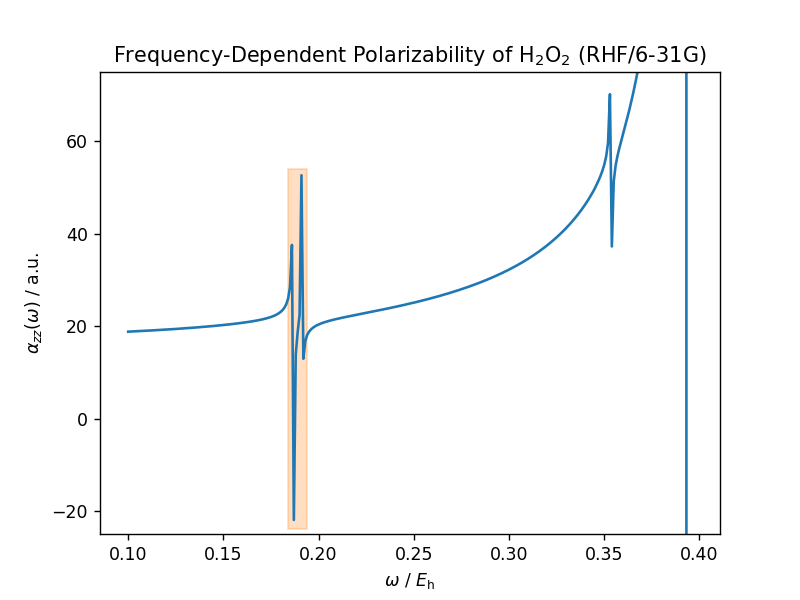

In [17]:
fig, ax = plt.subplots()
ax.plot(freq_full_list, alpha_full_list[:, 2, 2])
rect = patches.Rectangle((0.184, -24), 0.01, 78, linewidth=1, edgecolor='C1', facecolor='C1', alpha=.25)
ax.add_patch(rect)
ax.set_ylim(-25, 75)
ax.set_xlabel(r"$\omega$ / $E_\mathrm{h}$")
ax.set_ylabel(r"$\alpha_{zz} (\omega)$ / a.u.")
ax.set_title("Frequency-Dependent Polarizability of $\mathrm{H_2O_2}$ (RHF/6-31G)")
fig.show()

含频极化率的图像在处于分子的激发态区域会呈剧烈振荡。在后续文档中，我们会先更多地看上图中橙色区域表示的前两个激发态。由于上图对橙色部分的描述不很精细，我们下面做一份更精细的极化率图绘制。

In [18]:
fchk_helper = FormchkInterface("assets/H2O2_freq_polar_small_range.fch")
freq_small_list = fchk_helper.key_to_value("Frequencies for FD properties")[1:]
alpha_small_list = fchk_helper.key_to_value("Alpha(-w,w)").reshape(-1, 3, 3)[1:]

<IPython.core.display.Javascript object>


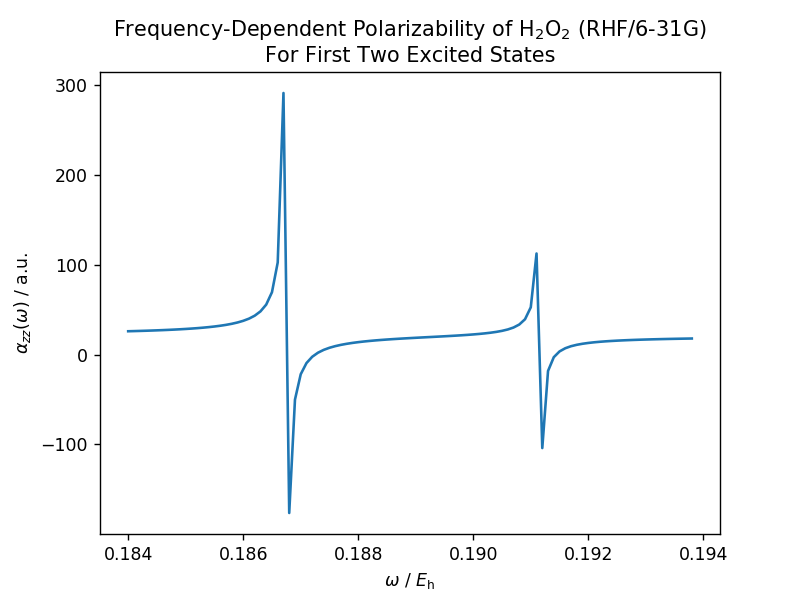

In [19]:
fig, ax = plt.subplots()
ax.plot(freq_small_list, alpha_small_list[:, 2, 2])
ax.set_xlabel(r"$\omega$ / $E_\mathrm{h}$")
ax.set_ylabel(r"$\alpha_{zz} (\omega)$ / a.u.")
ax.set_title("Frequency-Dependent Polarizability of $\mathrm{H_2O_2}$ (RHF/6-31G)\nFor First Two Excited States")
fig.show()

从这两张图的纵坐标的缩放关系来看，事实上，对于每一个振荡峰，其振荡是趋于无穷大的；并且其对应的频率恰好是分子 TD-HF 计算得到的激发能。这将会在后面的文档中叙述并验证。

## TD-HF 方程过程回顾

### TD-HF 方程与激发能

一般会认为，TD 方法是用于求解与电子激发过程有关的方法。最常用的应用即是求解激发能与跃迁偶极矩。我们在这一段先回顾这两者的计算过程。

在进行后续的描述前，我们会定义下述与 TD-HF 方程有关的张量或矩阵 `A` $\mathbb{A}_{ia, jb}$ 与 `B` $\mathbb{B}_{ia, jb}$：

$$
\begin{align}
\mathbb{A}_{ia, jb} &= (\varepsilon_a - \varepsilon_i) \delta_{ij} \delta_{ab} + 2 (ia|jb) - (ij|ab) \\
\mathbb{B}_{ia, jb} &= 2 (ia|jb) - (ib|ja)
\end{align}
$$

其中两个辅助变量为：

- `delta_ij` $\delta_{ij}$ 为占据轨道数维度的单位矩阵

- `delta_ab` $\delta_{ab}$ 为非占轨道数维度的单位矩阵

In [20]:
delta_ij, delta_ab = np.eye(nocc), np.eye(nvir)

In [21]:
A_iajb = (
    np.einsum("ia, ij, ab -> iajb", - e[so, None] + e[sv], delta_ij, delta_ab)
    + 2 * eri0_mo[so, sv, so, sv]
    - eri0_mo[so, so, sv, sv].swapaxes(1, 2))
B_iajb = (
    + 2 * eri0_mo[so, sv, so, sv]
    - eri0_mo[so, sv, so, sv].swapaxes(1, 3))

为了后文的代码方便，我们把双下标的矩阵记为 `A` $A_{PQ}$ 与 `B` $B_{PQ}$：

In [22]:
A = A_iajb.reshape(nocc*nvir, nocc*nvir)
B = B_iajb.reshape(nocc*nvir, nocc*nvir)

根据 TD-DFT 中的 Casida 方程 (TD-DFT 可以看作是 TD-HF 情形的扩展)，我们可以写出 TD-HF 的频率及其对应的本征向量为 $\omega_n, X_{ia}^n, Y_{ia}^n$，或者双下标记号的 $X_{P}^n, Y_{P}^n$。其中，$X_{ia}^n$ 有时称为第 $n$ 个激发态的激发矩阵，$Y_{ia}^n$ 则称退激发矩阵。这几者之间满足下述 TD-HF 矩阵方程。

$$
\begin{pmatrix} \mathbb{A} & \mathbb{B} \\ - \mathbb{B} & - \mathbb{A} \end{pmatrix}
\begin{pmatrix} \mathbf{X}^n \\ \mathbf{Y}^n \end{pmatrix}
= \omega_n \begin{pmatrix} \mathbf{X}^n \\ \mathbf{Y}^n \end{pmatrix}
$$

我们在程序上，记等式左边的大矩阵为 `AB`。

In [23]:
AB = np.block([
    [  A,   B],
    [- B, - A]
])
AB.shape

(234, 234)

我们首先解出上述矩阵的本征值 `eigs` 与本征向量 `xys`：

In [24]:
eigs, xys = np.linalg.eig(AB)

但我们会发现，我们本来预期的在 6-31G 基组下可解的激发态数量只有 $n_\mathrm{occ} n_\mathrm{vir} = 117$，但本征值数量却是 234 个。我们需要舍去所有负值的本征值。事实上，负值的本征值与正值的本征值之间有一一对应的关系。

In [25]:
(eigs < 0).sum()

117

我们舍去负本征值及其对应的本征向量，并对本征值作排序，得到正的本征值 `eigs_sorted` 及其相对应的本征向量 `xys_sorted`：

In [26]:
eigs_sorted = eigs[eigs.argsort()[int(eigs.size / 2):]]
xys_sorted = xys[:, eigs.argsort()[int(eigs.size / 2):]]

我们应当可以验证，上述本征值与本征向量确实满足 TD-HF 矩阵方程：

In [27]:
np.allclose(AB @ xys_sorted, eigs_sorted * xys_sorted)

True

最后，我们用 `td_eig` $\omega_n$、`td_x_unnormed` 未归一化的 $X^n_P$、`td_y_unnormed` 未归一化的 $Y^n_P$ 来重新整理上述的结果 `eigs_sorted` 与 `xys_sorted`。需要注意，变量 `td_x_unnormed` 的两个维度中，第一个维度为激发态 $n$，第二个维度为双下标 $P = ia$；尽管两个维度的大小都是 $n_\mathrm{occ} n_\mathrm{vir} = 117$，但意义完全不同。

In [28]:
td_eig = eigs_sorted
td_x_unnormed = xys_sorted.T[:, :nvir*nocc]
td_y_unnormed = xys_sorted.T[:, nvir*nocc:]

我们简单看一下最低激发能的几个激发态的能级大小，单位是原子单位或 Hartree $E_\mathrm{h}$：

In [29]:
eigs_sorted[:10]

array([0.18674, 0.19114, 0.35357, 0.39384, 0.41744, 0.42516, 0.45701, 0.4702 , 0.50732, 0.55833])

我们能看到最低的激发态中，有 0.187 与 0.191；这恰好与上面 Gaussian 绘制出来的含频极化率图中的两个振荡峰位置恰好吻合。这并非是偶然，并且我们会在后文进行更详细的描述。

### TD-HF 跃迁偶极矩

从基态波函数 $| 0 \rangle$ 到激发态波函数 $| n \rangle$ 的跃迁偶极矩可以写作 $\langle 0 | \hat d{}^t | n \rangle$ 或等价的 $- \langle 0 | t | n \rangle$；留意到 $t \in \{ x, y, z \}$。但实施上，我们尚不能写出激发态波函数 $| n \rangle$ 的具体形式。这个激发态波函数需要通过激发矩阵 $X_{ia}^n$ 与退激发矩阵 $Y_{ia}^n$ 来描述。

刚才的计算中，我们得到的本征向量是未经归一化的；它乘以任何非零常数，仍然会是 TD-HF 矩阵方程的本征向量。但我们可以使用激发与退激发，赋予这个本征向量以物理含义。其归一化条件是，态 $| n \rangle$ 的电子数守恒，即与 $| 0 \rangle$ 的电子数相同。在 RHF 问题下，这要求

$$
(X_{ia}^n)^2 - (Y_{ia}^n)^2 = 2
$$

我们令归一化过程中的中间量为 `td_renorm` $N_n = \frac{1}{2} \left( (X_{ia}^n)^2 - (Y_{ia}^n)^2 \right)$：

In [30]:
td_renorm = ((td_x_unnormed**2).sum(axis=1) - (td_y_unnormed**2).sum(axis=1)) / 2

那么重新归一化后的 `X` $X_P^n$ 与 `Y` $Y_P^n$ 为

In [31]:
X = td_x_unnormed / np.sqrt(td_renorm)[:, None]
Y = td_y_unnormed / np.sqrt(td_renorm)[:, None]

为了处理一些问题的便利，我们声明变量 `X_ia` $X_{ia}^n$ 与 `Y_ia` $Y_{ia}^n$；它们的维度均是 $(n, i, a)$：

In [32]:
X_ia = X.reshape(nocc*nvir, nocc, nvir)
Y_ia = Y.reshape(nocc*nvir, nocc, nvir)
X_ia.shape

(117, 9, 13)

以此为基础，我们可以写出 TD-HF 的跃迁偶极矩 `td_transdip`

$$
\langle 0 | \hat d{}^t | n \rangle = d_{ia}^t (X_{ia}^n + Y_{ia}^n)
$$

我们会打印出最低能级的 5 个激发态的跃迁偶极矩：

In [33]:
td_transdip = np.einsum("tia, nia -> nt", d_ia, X_ia + Y_ia)
td_transdip[:5]

array([[-0.00096,  0.01194, -0.10696],
       [-0.01912, -0.02168,  0.07287],
       [ 0.01189,  0.06348, -0.09044],
       [ 0.28032, -0.11958, -1.16236],
       [-0.11797,  0.0042 , -0.50674]])

这与 PySCF 所给出的跃迁偶极矩几乎是相同的，但符号上会有差异。我们认为这已经完整并成功地重复了跃迁偶极矩了。

In [34]:
scf_td.transition_dipole()[:5]

array([[-0.00096,  0.01194, -0.10696],
       [ 0.01912,  0.02168, -0.07287],
       [-0.01189, -0.06348,  0.09044],
       [-0.28032,  0.11958,  1.16236],
       [ 0.11797, -0.0042 ,  0.50674]])

需要注意，这可能与 Gaussian 计算得到的跃迁偶极矩的值接近但并不完全相等。这可能与 Gaussian 默认的 TD-HF 精度偏低有关。

## 静态极化率

### 偶极微扰下的 CP-HF 方程

这篇文档的一个目的是将 CP-HF 方程与 TD-HF 方程之间的关系作一个联系。因此，我们需要首先了解 CP-HF 方程在静态极化率中的工作过程。

<div class="alert alert-warning">

**提醒**

尽管我们确实可以用后续文档中的代码或公式计算得到一些结果，但这并不意味着成型的量化软件也使用这些算法。譬如对于 RHF 下静态极化率计算，通常更高效的做法是使用类似于 CP-HF 方程的 Z-Vector 方程。

</div>

由此，我们会写偶极微扰下的 CP-HF 方程为

$$
A'_{ia, jb} U^t_{jb} = d^t_{ia}
$$

下面简单但不严谨地回顾 CP-HF 方程的推导思路。我们在分子体系上，外加一个微扰偶极场，其大小是分子轨道基组下的 $d_{pq}^t$ 偶极矩阵，微扰哈密顿量为 $t$ (即单位方向为 $t$ 的电场微扰)。根据 RHF 的变分条件，任何外加微扰的哈密顿量 $t$ 都应该满足

$$
\frac{\partial F_{pq}}{\partial t} = 0
$$

通过该式，几乎可以直接得到 CP-HF 方程。方程的左边定义上是偶极积分，右边的 `A_p` $A'_{ia, jb}$ 为

$$
A'_{ia, jb} = (\varepsilon_a - \varepsilon_i) \delta_{ij} \delta_{ab} + 4 (ia|jb) - (ij|ab) - (ib|ja)
$$

而 `U_ia` $U_{jb}^t$ 称为 U 矩阵，表示的是与电子态密度在外加偶极微扰影响下的变化有关的量；一种导出式如下：

$$
\frac{\partial D_{pq}}{\partial t} = D_{pm} U^t_{mq} + D_{mq} U^t_{mp}
$$

因此，CP-HF 的一种直观的解释思路是，它求取的是分子受到外加偶极的微扰 $d^t_{ia}$ 下，电子态密度形变的大小，而这个大小是由 $U_{jb}^t$ U 矩阵刻画的。很容易想到的性质是，若外加偶极微扰趋于零，那么外加的形变微扰也趋于零矩阵。

下面我们来求取 CP-HF 方程，给出 `A_p` $A'_{PQ} = A'_{ia, jb}$ 与 `U_ia` $U_{jb}^t$。需要注意在这份文档中，角标顺序是 $ia, jb$ 而非 $ai, bj$；这可能与其它课本或文档的顺序不太相同，在一些矩阵的正负号上也可能存在差异。

In [35]:
A_p = (
    + np.einsum("ia, ij, ab -> iajb", - e[so, None] + e[sv], delta_ij, delta_ab)
    + 4 * eri0_mo[so, sv, so, sv]
    - eri0_mo[so, so, sv, sv].swapaxes(1, 2)
    - eri0_mo[so, sv, so, sv].swapaxes(1, 3)
).reshape(nvir*nocc, nvir*nocc)

In [36]:
U_ia = np.einsum("PQ, sQ -> sP", np.linalg.inv(A_p), d_P)
U_ia.shape = (3, nocc, nvir)

随后，根据求导法则与矩阵的对称性、反对称性的应用，应当可以得到静态极化率表达式为

$$
\alpha_{ts} (0) = \frac{\partial^2 E_\mathrm{RHF}}{\partial t \partial s} = \frac{\partial D_{ij} d^t_{ij} \delta_{ij}}{\partial s} = 4 d^t_{ia} U^s_{ia}
$$

In [37]:
4 * np.einsum("tia, sia -> ts", d_ia, U_ia)

array([[ 6.58142, -0.0841 , -1.45378],
       [-0.0841 ,  4.26835,  0.39969],
       [-1.45378,  0.39969, 17.89033]])

上述的结果与 Gaussian 计算所得到的静态极化率 `ref_alpha_static` 完全一致。

In [38]:
np.allclose(
    4 * np.einsum("tia, sia -> ts", d_ia, U_ia),
    ref_alpha_static)

True

### 矩阵求逆直接获得静态极化率

根据我们所写的 CP-HF 方程

$$
A'_{ia, jb} U^t_{jb} = d^t_{ia}
$$

我们应当很容易地想到，如果我们有足够的计算能力，可以对四脚标矩阵 $A'_{ia, jb}$ 求逆，那么我们不一定需要明确写出 U 矩阵，也一样可以求得静态极化率：

$$
\alpha_{ts} (0) = 4 d^t_{ia} (A'{}^{-1})_{ia, jb} d^s_{ia}
$$

当然，上面的计算过程实际上是用双下标 ($P = ia$, $Q = jb$) 表达式实现的：

$$
\alpha_{ts} (0) = 4 d^t_{P} (A'{}^{-1})_{PQ} d^s_{Q}
$$

In [39]:
np.allclose(4 * np.einsum("tP, PQ, sQ -> ts", d_P, np.linalg.inv(A_p), d_P), ref_alpha_static)

True

### 跃迁偶极矩获得静态极化率

CP-HF 方程求解静态极化率的思路是非常直观的；但静态极化率还可以通过 TD-HF 的方式求得。表面上，这两种推导思路和前提几乎完全不同；但我们却可以得到数值上 **完全** (而非近似) 相等的静态极化率。这里我们会作说明。

我们首先不加说明地直接给出 TD-HF 方式给出的静态极化率公式：

$$
\alpha_{ts} (0) = 2 \frac{\langle 0 | \hat d{}^t | n \rangle \langle n | \hat d{}^s | 0 \rangle}{\omega_n}
$$

它很容易化为程序表达式：

In [40]:
2 * np.einsum("nt, n, ns -> ts", td_transdip, 1 / td_eig, td_transdip)

array([[ 6.58142, -0.0841 , -1.45378],
       [-0.0841 ,  4.26835,  0.39969],
       [-1.45378,  0.39969, 17.89033]])

我们与上面用 CP-HF 方式计算得到的静态极化率作对比，不难发现两者的值是完全相等的。可以用下述程序与 Gaussian 的计算结果作对比：

In [41]:
np.allclose(2 * np.einsum("nt, n, ns -> ts", td_transdip, 1 / td_eig, td_transdip), ref_alpha_static)

True

这说明，对于静态极化率问题，TD-HF 与 CP-HF 方法之间有着确实的联系。我们下面就使用 TD-HF 方程来导出 CP-HF 方程的结果，或者说从简单的线性代数角度证明：

$$
\alpha_{ts} (0) = 2 \frac{\langle 0 | \hat d{}^t | n \rangle \langle n | \hat d{}^s | 0 \rangle}{\omega_n} = 4 d^t_{P} (A'{}^{-1})_{PQ} d^s_{Q}
$$

### 静态极化率下 TD-HF 方程与 CP-HF 方程的等价推导

这里我们会给出静态情况下，TD-HF 与 CP-HF 方程的推演过程。对于动态 (含频) 过程的推演，我们会放在文档的后面描述。

首先，我们会说明 TD-HF 方程的 `A` $\mathbb{A}_{PQ}$ 与 `B` $\mathbb{B}_{PQ}$ 之和，恰好是 CP-HF 方程的 `A_p` $A'_{PQ}$：

$$
A'_{PQ} = \mathbb{A}_{PQ} + \mathbb{B}_{PQ}
$$

In [42]:
np.allclose(A + B, A_p)

True

利用 $\langle 0 | \hat d{}^t | n \rangle = d_{ia}^t (X_{ia}^n + Y_{ia}^n)$，我们重新用 $X_P^n, Y_P^n$ 的形式写一下 TD-HF 方程所给出的极化率公式：

$$
\alpha_{ts} (0) = 2 \frac{d_P^t d_Q^s (X_P^n + Y_P^n) (X_Q^n + Y_Q^n)}{\omega_n}
$$

In [43]:
np.allclose(2 * np.einsum("tP, sQ, nP, nQ, n -> ts", d_P, d_P, X + Y, X + Y, 1 / td_eig), ref_alpha_static)

True

回顾到 TD-HF 方程

$$
\begin{pmatrix} \mathbb{A} & \mathbb{B} \\ - \mathbb{B} & - \mathbb{A} \end{pmatrix}
\begin{pmatrix} \mathbf{X}^n \\ \mathbf{Y}^n \end{pmatrix}
= \omega_n \begin{pmatrix} \mathbf{X}^n \\ \mathbf{Y}^n \end{pmatrix}
$$

我们可以推知，$(\mathbb{A} + \mathbb{B}) (\mathbf{X}^n + \mathbf{Y}^n) = \omega_n (\mathbf{X}^n - \mathbf{Y}^n)$，或者写为角标求和的形式，

$$
(\mathbb{A} + \mathbb{B})_{RQ} (\mathbf{X}^n + \mathbf{Y}^n)_Q = \omega_n (\mathbf{X}^n - \mathbf{Y}^n)_R
$$

那么我们可以将上式，以及矩阵逆关系 $(\mathbb{A} + \mathbb{B})^{-1} (\mathbb{A} + \mathbb{B}) = \mathbb{1}$ 即

$$
(\mathbb{A} + \mathbb{B})^{-1}_{SR} (\mathbb{A} + \mathbb{B})_{RQ} = \delta_{SQ}
$$

代入到上面提到的 TD-HF 的极化率公式中，得到

$$
\begin{align}
\alpha_{ts} (0)
&= 2 \frac{d_P^t d_Q^s (X_P^n + Y_P^n) (\mathbb{A} + \mathbb{B})^{-1}_{QR} (\mathbb{A} + \mathbb{B})_{RQ} (X_Q^n + Y_Q^n)}{\omega_n} \\
&= 2 d_P^t d_Q^s (X_P^n + Y_P^n) (\mathbb{A} + \mathbb{B})^{-1}_{QR} (X_R^n - Y_R^n)
\end{align}
$$

随后我们需要利用 $\mathbf{X}^n, \mathbf{Y}^n$ 的正交化条件。正交化条件我们曾经在给出 $\mathbf{X}^n, \mathbf{Y}^n$ 时确实利用到过，但其更有用的推论是 $(\mathbf{X} + \mathbf{Y})^\dagger (\mathbf{X} - \mathbf{Y}) = 2 \cdot \mathbb{1}$

$$
(\mathbf{X}^n + \mathbf{Y}^n)_P (\mathbf{X}^n - \mathbf{Y}^n)_R = 2 \delta_{PR}
$$

我们可以用下面的程序来说明这一问题：

In [44]:
np.einsum("nP, nQ -> PQ", X + Y, X - Y)

array([[ 2., -0., -0., ..., -0., -0.,  0.],
       [-0.,  2.,  0., ..., -0., -0., -0.],
       [-0.,  0.,  2., ..., -0., -0., -0.],
       ...,
       [-0., -0.,  0., ...,  2.,  0.,  0.],
       [ 0., -0., -0., ...,  0.,  2., -0.],
       [-0.,  0.,  0., ...,  0., -0.,  2.]])

那么我们就可以将上面的极化率公式化为

$$
\begin{align}
\alpha_{ts} (0)
&= 2 d_P^t d_Q^s (\mathbb{A} + \mathbb{B})^{-1}_{QR} \cdot 2 \delta_{PR} \\
&= 4 d_Q^s (\mathbb{A} + \mathbb{B})^{-1}_{QP} d_P^t \\
&= 4 d_Q^s (A'{}^{-1})_{QP} d^t_P
\end{align}
$$

我们知道，上式的等式左边是对 $Q, P$ 双下标进行求和。作为被求和的两个下标是可以被交换的，因此我们可以将上式写为

$$
\alpha_{ts} (0) = 4 d_P^s (A'{}^{-1})_{PQ} d^t_Q
$$

In [45]:
np.allclose(4 * np.einsum("sP, PQ, tQ -> ts", d_P, np.linalg.inv(A_p), d_P), ref_alpha_static)

True

上述推导并没有结束。我们回顾到刚才 CP-HF 所给出的极化率并不是上述的表达式，而是交换了 $t, s$ 两者的极化率：

$$
\alpha_{ts} (0) = 4 d_P^t (A'{}^{-1})_{PQ} d^s_Q
$$

In [46]:
np.allclose(4 * np.einsum("tP, PQ, sQ -> ts", d_P, np.linalg.inv(A_p), d_P), ref_alpha_static)

True

从极化率作为能量的二阶梯度的角度来说，这是因为被求导量可交换，因此极化率具有 Hermite 性质：

$$
\alpha_{ts} (\omega) = \alpha_{st} (\omega)
$$

到这一步为止，从 TD-HF 方程给出的极化率，成功地推导出了 CP-HF 方程所给出的极化率。

## 含频极化率

### 跃迁偶极矩获得含频极化率

我们先不对含频极化率作公式上的分析，先只看数值的结果，并与 Gaussian 输出的结果进行比较。

我们仍然不加说明地直接给出 TD-HF 方式给出的含频极化率公式：

$$
\alpha_{ts} (\omega_n) = \frac{\langle 0 | \hat d{}^t | n \rangle \langle n | \hat d{}^s | 0 \rangle}{\omega_n - \omega} + \frac{\langle 0 | \hat d{}^t | n \rangle \langle n | \hat d{}^s | 0 \rangle}{\omega_n + \omega}
$$

需要留意的是，$\omega_n$ 为分子通过 TD-HF 方程解出来的激发能，而 $\omega$ 是外加的、任意的激发光束频率；两者除了单位一致外几乎完全无关。

上述公式中，前一项称为共振项 (resonance term)，后一项称为非共振项。这两项在不同频率下的行为可以很容易地用图片表示出来；当 $\omega$ 接近激发频率 $\omega_n$ 时产生断点行为的项是共振项。

它也很容易化为程序表达式。我们用下述函数 `freq_to_alpha`，输入 `omega` $\omega$ 来返回含频频率 $\alpha_{ts} (\omega_n)$；并将其中的共振项与非共振项拆分为函数 `freq_to_res` 与 `freq_to_nonres`：

In [47]:
freq_to_res    = lambda omega: np.einsum("nt, n, ns -> ts", td_transdip, 1 / (td_eig - omega), td_transdip)
freq_to_nonres = lambda omega: np.einsum("nt, n, ns -> ts", td_transdip, 1 / (td_eig + omega), td_transdip)
freq_to_alpha  = lambda omega: freq_to_res(omega) + freq_to_nonres(omega)

若外加激发光束频率为 0，那么将退化到静态极化率的情形中：

In [48]:
freq_to_alpha(0)

array([[ 6.58142, -0.0841 , -1.45378],
       [-0.0841 ,  4.26835,  0.39969],
       [-1.45378,  0.39969, 17.89033]])

In [49]:
np.allclose(freq_to_alpha(0), ref_alpha_static)

True

在静态情况下，共振项与非共振项对总极化率的贡献是相等的：

In [50]:
freq_to_res(0)

array([[ 3.29071, -0.04205, -0.72689],
       [-0.04205,  2.13418,  0.19984],
       [-0.72689,  0.19984,  8.94517]])

我们现在想要尝试与 Gaussian 的数据进行核对并绘制图片。回顾到我们曾经定义过 `freq_full_list` 为较广的频率范围，其对应的 Gaussian 计算的极化率在 `alpha_full_list`。我们将用 `freq_to_alpha` 函数绘制的 $\alpha_{zz} (\omega)$ 极化率分量放在 numpy 张量列表 `alpha_zz_full_calc` 中；并将其共振项与非共振项分别放在 `alpha_zz_full_res` 与 `alpha_zz_full_nonres`：

In [51]:
alpha_zz_full_calc   = np.vectorize(lambda omega: freq_to_alpha (omega)[2, 2])(freq_full_list)
alpha_zz_full_res    = np.vectorize(lambda omega: freq_to_res   (omega)[2, 2])(freq_full_list)
alpha_zz_full_nonres = np.vectorize(lambda omega: freq_to_nonres(omega)[2, 2])(freq_full_list)

下面我们绘制在这个频率区间内，Gaussian 计算得到的结果与我们用上面跃迁偶极矩的公式获得的结果作比较。尽管在断点附近两者表现略有不同，但稳定区间的含频极化率与 Gaussian 的结果基本上是一致的。

<IPython.core.display.Javascript object>


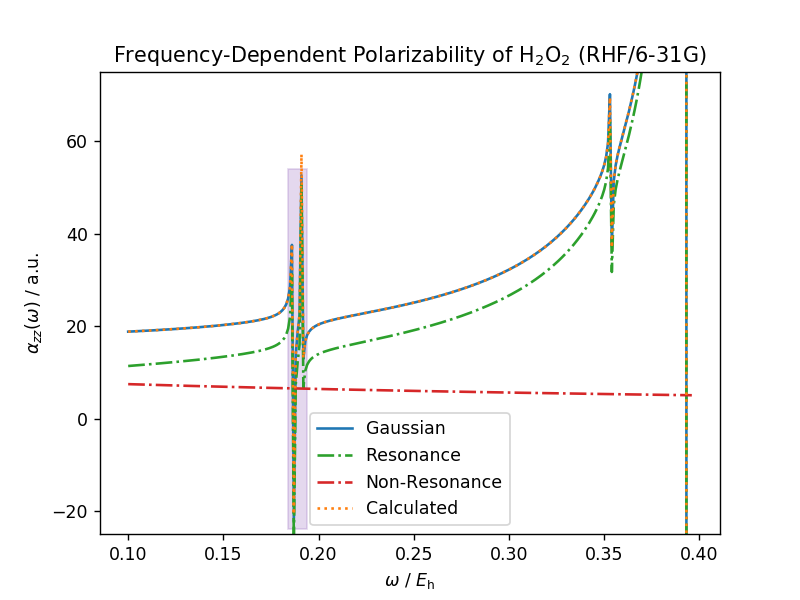

In [52]:
fig, ax = plt.subplots()
ax.plot(freq_full_list, alpha_full_list[:, 2, 2], label="Gaussian")
ax.plot(freq_full_list, alpha_zz_full_res, linestyle="-.", c="C2", label="Resonance")
ax.plot(freq_full_list, alpha_zz_full_nonres, linestyle="-.", c="C3", label="Non-Resonance")
ax.plot(freq_full_list, alpha_zz_full_calc, linestyle=":", label="Calculated")
rect = patches.Rectangle((0.184, -24), 0.01, 78, linewidth=1, edgecolor='C4', facecolor='C4', alpha=.25)
ax.add_patch(rect)
ax.set_ylim(-25, 75)
ax.set_xlabel(r"$\omega$ / $E_\mathrm{h}$")
ax.set_ylabel(r"$\alpha_{zz} (\omega)$ / a.u.")
ax.set_title("Frequency-Dependent Polarizability of $\mathrm{H_2O_2}$ (RHF/6-31G)")
ax.legend()
fig.show()

对于前两个激发态能量的窄区间中，我们的结果在非断点附近其实与 Gaussian 的结果也基本一致：

In [53]:
alpha_zz_small_calc   = np.vectorize(lambda omega: freq_to_alpha (omega)[2, 2])(freq_small_list)
alpha_zz_small_res    = np.vectorize(lambda omega: freq_to_res   (omega)[2, 2])(freq_small_list)
alpha_zz_small_nonres = np.vectorize(lambda omega: freq_to_nonres(omega)[2, 2])(freq_small_list)

<IPython.core.display.Javascript object>


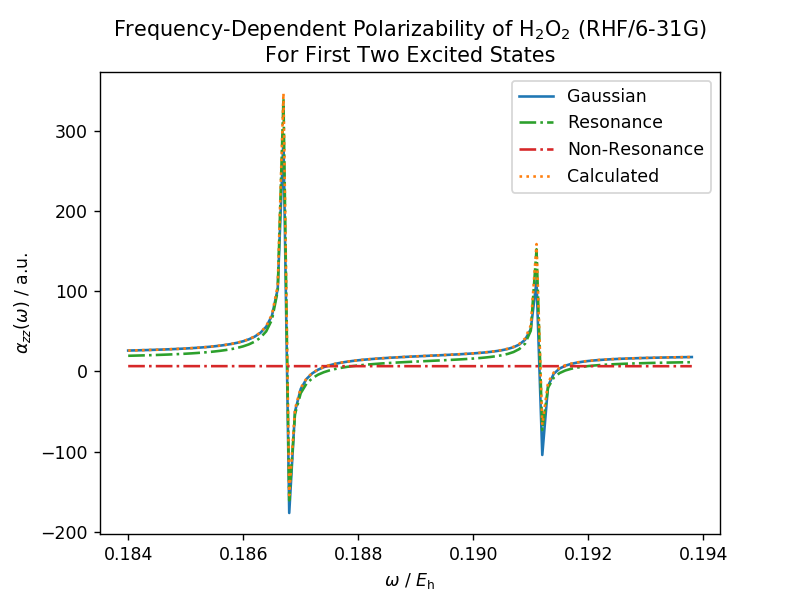

In [54]:
fig, ax = plt.subplots()
ax.plot(freq_small_list, alpha_small_list[:, 2, 2], label="Gaussian")
ax.plot(freq_small_list, alpha_zz_small_res, linestyle="-.", c="C2", label="Resonance")
ax.plot(freq_small_list, alpha_zz_small_nonres, linestyle="-.", c="C3", label="Non-Resonance")
ax.plot(freq_small_list, alpha_zz_small_calc, linestyle=":", label="Calculated")
ax.set_xlabel(r"$\omega$ / $E_\mathrm{h}$")
ax.set_ylabel(r"$\alpha_{zz} (\omega)$ / a.u.")
ax.set_title("Frequency-Dependent Polarizability of $\mathrm{H_2O_2}$ (RHF/6-31G)\nFor First Two Excited States")
ax.legend()
fig.show()

我们认为我们确实正确计算了含频极化率。在断点附近的行为应当被认为是数值上的微小差别；并且我们认为，在断点 (共振) 处附近产生的极化率的主要贡献部分应为极化率的共振项所产生。

### TD-HF 方程含频极化率及其与跃迁偶极矩的关联

上一大段中，我们仅仅是用了 TD-HF 给出的跃迁偶极矩结果，反推出了 CP-HF 的公式。但我们并没有介绍过最原始的 TD-HF 极化率表达式。下面我们会从最普遍的公式，推导含频极化率的表达式。下面的推导过程中，程序的部分会少一些。

我们从 TD-DFT 的 Casida 方程开始；Casida 方程可以简单地退化到 TD-HF 的情形。我们上面在推演激发频率 $\omega_n$ 时，也提到了 Casida 方程；

$$
\begin{pmatrix} \mathbb{A} & \mathbb{B} \\ - \mathbb{B} & - \mathbb{A} \end{pmatrix}
\begin{pmatrix} \mathbf{X}^n \\ \mathbf{Y}^n \end{pmatrix}
= \omega_n \begin{pmatrix} \mathbf{X}^n \\ \mathbf{Y}^n \end{pmatrix}
\tag{1}
$$

但下面的 Casida 方程具有更为广泛的适用情形。我们引入外加的偶极微扰 `d_P` $\mathbf{d}^t$ 与外加激发光束频率 `omega` $\omega$ 的微扰，则有

$$
\begin{pmatrix} \mathbb{A} & \mathbb{B} \\ \mathbb{B} & \mathbb{A} \end{pmatrix}
\begin{pmatrix} \mathbf{X}'{}^t \\ \mathbf{Y}'{}^t \end{pmatrix}
= \omega \begin{pmatrix} \mathbf{X}'{}^t \\ - \mathbf{Y}'{}^t \end{pmatrix} +
\begin{pmatrix} 2 \mathbf{d}^t \\ 2 \mathbf{d}^t \end{pmatrix}
\tag{2}
$$

这里有不少符号上的区别。首先，(1) 式的激发态频率 $\omega_n$ 与 (2) 式的外加光束的频率 $\omega$ 并不相同；但 (2) 在一种情形下确实地可以退化到 (1) 式。若现在没有外加偶极微扰 $\mathbf{d}^t$，那么外加光束必须要恰好处于分子电子的激发频率上，分子的电子云微扰变化才能被允许 (即使时间非常短，这对应的是紫外光谱电子态的平均寿命)。而电子的激发频率不一定只有一个，因此会产生上下标 $n$ 表示不同的激发频率；第 $n$ 个激发态电子云微扰的形变大小和取向由 $\mathbf{X}^n$ 与 $\mathbf{Y}^n$ 共同决定；它们将会产生第 $n$ 个激发态的跃迁密度 $\rho^n (\boldsymbol{r}, \omega)$ (下式对 $i, a$ 求和)：

$$
\rho^n (\boldsymbol{r}, \omega_n) = (X_{ia}^n + Y_{ia}^n) \phi_i (\boldsymbol{r}) \phi_a (\boldsymbol{r})
$$

其次，(2) 式的 $\mathbf{X}'{}^t$ 若不看偶极激发方向 $t$，它还比 (1) 式的 $\mathbf{X}^n$ 少了 $n$ 并多了一撇；多的一撇是为了区分两者。之所以这里没有 $n$，我们可以这样考虑：在某一个特定的外加偶极微扰 $\mathbf{d}^t$ 与频率 $\omega$ 微扰下，分子的电子云确实会发生改变；但这种改变的方式一般是唯一的 (简并情况我们不作讨论)。这种形变所产生的密度形式也是类似的 (下式对 $i, a$ 求和)：

$$
\rho (\boldsymbol{r}, \mathbf{d}^t, \omega) = (X_{ia}'{}^t + Y_{ia}'{}^t) \phi_i (\boldsymbol{r}) \phi_a (\boldsymbol{r})
$$

含频极化率可以通过上述的形变密度在偶极算符的作用下给出：

$$
\alpha_{ts} (\omega)
= \int -s \cdot \rho (\boldsymbol{r}, \mathbf{d}^t, \omega) \, \mathrm{d} \boldsymbol{r}
= (X_{ia}'{}^t + Y_{ia}'{}^t) \int -s \cdot \phi_i (\boldsymbol{r}) \phi_a (\boldsymbol{r}) \, \mathrm{d} \boldsymbol{r}
= (X_{ia}'{}^t + Y_{ia}'{}^t) d_{ia}^s = (X_P'{}^t + Y_P'{}^t) d_P^s
$$

其中关于 $X_P'{}^t, Y_P'{}^t$ 需要通过 Casida 方程求取。(2) 式经过简单的代数处理后得到 (3) 式：

$$
\begin{pmatrix} \mathbb{A} - \omega \mathbb{1} & \mathbb{B} \\ - \mathbb{B} & - \mathbb{A} - \omega \mathbb{1} \end{pmatrix}
\begin{pmatrix} \mathbf{X}'{}^t \\ \mathbf{Y}'{}^t \end{pmatrix}
= \begin{pmatrix} 2 \mathbf{d}^t \\ - 2 \mathbf{d}^t \end{pmatrix}
\tag{3}
$$

那么我们有

$$
\alpha_{ts} (\omega) = (X_P'{}^t + Y_P'{}^t) d_P^s
= \begin{pmatrix} \mathbf{d}^s & \mathbf{d}^s \end{pmatrix} \begin{pmatrix} \mathbf{X}'{}^t \\ \mathbf{Y}'{}^t \end{pmatrix}
= \begin{pmatrix} \mathbf{d}^s & \mathbf{d}^s \end{pmatrix}
\begin{pmatrix} \mathbb{A} - \omega \mathbb{1} & \mathbb{B} \\ - \mathbb{B} & - \mathbb{A} - \omega \mathbb{1} \end{pmatrix}^{-1}
\begin{pmatrix} 2 \mathbf{d}^t \\ - 2 \mathbf{d}^t \end{pmatrix}
\tag{4}
$$

对于不带频率的情形，我们可以用下面的代码验证：

In [55]:
np.einsum("tP, PQ, sQ -> ts",
          np.concatenate([d_P, d_P], axis=1),
          np.linalg.inv(AB),
          np.concatenate([2 * d_P, - 2 * d_P], axis=1))

array([[ 6.58142, -0.0841 , -1.45378],
       [-0.0841 ,  4.26835,  0.39969],
       [-1.45378,  0.39969, 17.89033]])

而对于带频率的情形，我们可以举一个 $\omega = 0.186 \, E_\mathrm{h}$ 的例子：

In [56]:
omega = 0.186
np.einsum("tP, PQ, sQ -> ts",
          np.concatenate([d_P, d_P], axis=1),
          np.linalg.inv(AB - np.eye(nvir*nocc*2) * omega),
          np.concatenate([2 * d_P, - 2 * d_P], axis=1))

array([[ 7.28458, -0.05683, -2.08145],
       [-0.05683,  4.79845, -1.39731],
       [-2.08145, -1.39731, 37.73368]])

但这样的表达式 (4) 并没有出现跃迁偶极矩。下面我们需要简化表达式。

首先，我们回顾式 (3)，得到方程组

$$
\begin{align}
\mathbb{A} \mathbf{X}'{}^t + \mathbb{B} \mathbf{Y}'{}^t - \omega \mathbf{X}'{}^t &= 2 \mathbf{d}^t \\
\mathbb{B} \mathbf{X}'{}^t + \mathbb{A} \mathbf{Y}'{}^t + \omega \mathbf{Y}'{}^t &= 2 \mathbf{d}^t
\end{align}
$$

两式加减后，可以得到

$$
\begin{align}
(\mathbb{A} + \mathbb{B}) (\mathbf{X}'{}^t + \mathbf{Y}'{}^t) - \omega (\mathbf{X}'{}^t - \mathbf{Y}'{}^t) &= 4 \mathbf{d}^t \tag{5} \\
(\mathbb{A} - \mathbb{B}) (\mathbf{X}'{}^t - \mathbf{Y}'{}^t) &= \omega (\mathbf{X}'{}^t + \mathbf{Y}'{}^t) \tag{6}
\end{align}
$$

利用 (6) 式替换 (5) 式中出现的 $(\mathbf{X}'{}^t - \mathbf{Y}'{}^t)$，有

$$
(\mathbb{A} - \mathbb{B}) (\mathbb{A} + \mathbb{B}) (\mathbf{X}'{}^t + \mathbf{Y}'{}^t) - \omega^2 (\mathbf{X}'{}^t + \mathbf{Y}'{}^t) = 4 (\mathbb{A} - \mathbb{B}) \mathbf{d}^t
$$

或者，等价地，

$$
(\mathbf{X}'{}^t + \mathbf{Y}'{}^t) = 4 \left( (\mathbb{A} - \mathbb{B}) (\mathbb{A} + \mathbb{B}) - \omega^2 \mathbb{1} \right)^{-1} (\mathbb{A} - \mathbb{B}) \mathbf{d}^t
$$

两边再乘上 $\mathbf{d}^s$，就得到了含频极化率：

$$
\alpha_{ts} (\omega) = 4 \mathbf{d}^s{}^\dagger \left( (\mathbb{A} - \mathbb{B}) (\mathbb{A} + \mathbb{B}) - \omega^2 \mathbb{1} \right)^{-1} (\mathbb{A} - \mathbb{B}) \mathbf{d}^t \tag{7}
$$

以 $\omega = 0.186 \, E_\mathrm{h}$ 来表达上式，则有

In [57]:
4 * np.einsum("tP, PR, RQ, sQ -> ts", d_P, np.linalg.inv((A - B) @ (A + B) - omega**2 * np.eye(nvir*nocc)), A - B, d_P)

array([[ 7.28458, -0.05683, -2.08145],
       [-0.05683,  4.79845, -1.39731],
       [-2.08145, -1.39731, 37.73368]])

上述结果与通过式 (4) 给出的结果一致。

下面我们引入一个技巧。我们将会对矩阵 $(\mathbb{A} - \mathbb{B}) (\mathbb{A} + \mathbb{B}) - \omega^2 \mathbb{1}$ 作逆矩阵分解。我们采用的做法是分析矩阵的特征值与特征向量。依据我们对式 (1) 形式的 Casida 方程的讨论，我们应当容易推知

$$
(\mathbb{A} - \mathbb{B}) (\mathbb{A} + \mathbb{B}) (\mathbf{X}^n + \mathbf{Y}^n) = \omega_n^2 (\mathbf{X}^n + \mathbf{Y}^n) \tag{8}
$$

In [58]:
np.allclose((A - B) @ (A + B) @ (X + Y).T, td_eig**2 * (X + Y).T)

True

我们曾经指出过正交条件为 $(\mathbf{X} + \mathbf{Y})^\dagger (\mathbf{X} - \mathbf{Y}) = 2 \cdot \mathbb{1}$，因此，若将 $\mathbf{X}, \mathbf{Y}$ 分别看作是横向维度 $n$ 表示激发态，纵向维度 $P$ 表示激发和退激发分量的方形矩阵：

$$
\mathbf{X} = \begin{pmatrix} \mathbf{X}^1{}^\dagger \\ \mathbf{X}^2{}^\dagger \\ \vdots \\ \mathbf{X}^{n_\mathrm{occ} n_\mathrm{vir}}{}^\dagger \end{pmatrix}
$$

那么 $(\mathbf{X} + \mathbf{Y})$ 与 $(\mathbf{X} - \mathbf{Y})$ 之间存在互逆关系：

$$
(\mathbf{X} + \mathbf{Y})^{-1} = \frac{1}{2} (\mathbf{X} - \mathbf{Y})^\dagger
$$

In [59]:
np.allclose(np.linalg.inv(X + Y), 0.5 * (X - Y).T)

True

因此，一定程度上，我们可以认为 $(\mathbf{X} + \mathbf{Y})$ 与 $(\mathbf{X} - \mathbf{Y})$ 两者是相互对偶的向量组。注意区别这里的 $\mathbf{X}$ 引入的目的是为了刻画 $\mathbb{A}, \mathbb{B}$ 的性质，而与 $\mathbf{X}'{}^t$ 没有直接关联。

这种向量组满足下述特征向量分解公式：

$$
(\mathbb{A} - \mathbb{B}) (\mathbb{A} + \mathbb{B}) = \frac{1}{2} (\mathbf{X} + \mathbf{Y}) \mathbf{\Omega}^2 (\mathbf{X} - \mathbf{Y})^\dagger
$$

其中，

$$
\mathbf{\Omega} =
\begin{pmatrix}
\omega_1 & 0 & \cdots & 0 \\
0 & \omega_2 & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & \omega_{n_\mathrm{occ} n_\mathrm{vir}}
\end{pmatrix}
$$

In [60]:
np.allclose(
    0.5 * np.einsum("nP, n, nQ -> PQ", X + Y, td_eig**2, X - Y),
    (A - B) @ (A + B))

True

下面我们来讨论矩阵 $(\mathbb{A} - \mathbb{B}) (\mathbb{A} + \mathbb{B}) - \omega^2 \mathbb{1}$。我们容易从式 (8) 推得

$$
\left( (\mathbb{A} - \mathbb{B}) (\mathbb{A} + \mathbb{B}) - \omega^2 \mathbb{1} \right) (\mathbf{X}^n + \mathbf{Y}^n) = (\omega_n^2 - \omega^2) (\mathbf{X}^n + \mathbf{Y}^n)
$$

即上述方程的本征向量仍然是 $(\mathbf{X}^n + \mathbf{Y}^n)$，但本征值却变为 $\omega_n^2 - \omega^2$。因此，

$$
\left( (\mathbb{A} - \mathbb{B}) (\mathbb{A} + \mathbb{B}) - \omega^2 \mathbb{1} \right)^{-1} = \left( \frac{1}{2} (\mathbf{X} + \mathbf{Y}) (\mathbf{\Omega}^2 - \omega^2 \mathbb{1}) (\mathbf{X} - \mathbf{Y})^\dagger \right)^{-1} = \frac{1}{2} (\mathbf{X} + \mathbf{Y}) (\mathbf{\Omega}^2 - \omega^2 \mathbb{1})^{-1} (\mathbf{X} - \mathbf{Y})^\dagger \tag{9}
$$

上式中 $(\mathbf{\Omega}^2 - \omega^2 \mathbb{1})^{-1}$ 是一个极为容易计算的对角矩阵。$\omega = 0.186 \, E_\mathrm{h}$ 下，程序表示上述过程则为

In [61]:
np.allclose(
    0.5 * np.einsum("nP, n, nQ -> PQ", X + Y, 1 / (td_eig**2 - omega**2), X - Y),
    np.linalg.inv((A - B) @ (A + B) - omega**2 * np.eye(nvir*nocc)))

True

将式 (9) 代入到式 (7)，得到

$$
\alpha_{ts} (\omega) = 2 \mathbf{d}^s{}^\dagger (\mathbf{X} + \mathbf{Y}) (\mathbf{\Omega}^2 - \omega^2 \mathbb{1})^{-1} (\mathbf{X} - \mathbf{Y})^\dagger (\mathbb{A} - \mathbb{B}) \mathbf{d}^t
$$

利用极化率的 Hermite 性，并将上述矩阵表达式展开为求和式，得到

$$
\alpha_{ts} (\omega) = 2 d_P^t (\mathbf{X}^n + \mathbf{Y}^n)_P \cdot \frac{1}{\omega_n^2 - \omega^2} \cdot (\mathbf{X}^n - \mathbf{Y}^n)_R (\mathbb{A} - \mathbb{B})_{RQ} d_Q^s
$$

In [62]:
2 * np.einsum("tP, nP, n, nR, RQ, sQ", d_P, X + Y, 1 / (td_eig**2 - omega**2), X - Y, A - B, d_P)

array([[ 7.28458, -0.05683, -2.08145],
       [-0.05683,  4.79845, -1.39731],
       [-2.08145, -1.39731, 37.73368]])

若要化简上式，首先需要利用 $(\mathbb{A} - \mathbb{B})_{RQ}$ 事实上恰好是一个 Hermite 矩阵：

In [63]:
np.allclose(A - B, (A - B).T)

True

随后注意到 $(\mathbb{A} - \mathbb{B})_{QR} (\mathbf{X}^n - \mathbf{Y}^n)_R = \omega_n (\mathbf{X}^n + \mathbf{Y}^n)_Q$；于是上式化为

$$
\alpha_{ts} (\omega) = 2 d_P^t (\mathbf{X}^n + \mathbf{Y}^n)_P \cdot \frac{\omega_n}{\omega_n^2 - \omega^2} \cdot (\mathbf{X}^n + \mathbf{Y}^n)_Q d_Q^s
$$

我们留意到跃迁偶极矩的定义是 $\langle 0 | \hat d{}^t | n \rangle = d_P^t (\mathbf{X}^n + \mathbf{Y}^n)_P$，并且利用下面的小技巧：

$$
\frac{\omega_n}{\omega_n^2 - \omega^2} = \frac{1}{2} \left( \frac{1}{\omega_n - \omega} - \frac{1}{\omega_n + \omega} \right)
$$

我们就可以推知，

$$
\alpha_{ts} (\omega) = \frac{\langle 0 | \hat d{}^t | n \rangle \langle n | \hat d{}^s | 0 \rangle}{\omega_n - \omega} + \frac{\langle 0 | \hat d{}^t | n \rangle \langle n | \hat d{}^s | 0 \rangle}{\omega_n + \omega}
$$

In [64]:
(
    + np.einsum("tP, nP, n, nQ, sQ -> ts", d_P, X + Y, 1 / (td_eig - omega), X + Y, d_P)
    + np.einsum("tP, nP, n, nQ, sQ -> ts", d_P, X + Y, 1 / (td_eig + omega), X + Y, d_P)
)

array([[ 7.28458, -0.05683, -2.08145],
       [-0.05683,  4.79845, -1.39731],
       [-2.08145, -1.39731, 37.73368]])

这就完成了从普适的 Casida 方程推演得到跃迁偶极矩表示的极化率的公式了。

若接受 Casida 方程的假设前提，那么上述的推演将会是严格的。

### TD-HF 方程含频极化率与 CP-HF 方程间的关系

我们先回顾静态极化率求取时所使用的 CP-HF 方程：

$$
A'_{ia, jb} U^t_{jb} = d^t_{ia}
$$

写为双下标的形式，则为

$$
A'_{PQ} U^t_Q = d^t_P
$$

写为矩阵形式，则为

$$
\mathbf{A}' \mathbf{U}^t = \mathbf{d}^t
$$

留意到 $A'_{PQ} = (\mathbb{A} + \mathbb{B})_{PQ}$，因此上式这对应到 Casida 方程的一个导出式 (5)。若 $\omega = 0$，则

$$
(\mathbb{A} + \mathbb{B}) (\mathbf{X}'{}^t + \mathbf{Y}'{}^t) = 4 \mathbf{d}^t
$$

因此，在静态情形 $\omega = 0$ 下，$\mathbf{U}^t = \frac{1}{4} (\mathbf{X}' + \mathbf{Y}')$。

但若 $\omega \neq 0$，那么式 (5) 应写作

$$
\left( (\mathbb{A} + \mathbb{B}) - \omega (\mathbb{A} - \mathbb{B})^{-1} \right) (\mathbf{X}'{}^t + \mathbf{Y}'{}^t) = 4 \mathbf{d}^t
$$

若我们拓展 CP-HF 方程为含频形式

$$
\mathbf{A}' (\omega) \mathbf{U}^t (\omega) = \mathbf{d}^t
$$

并且极化率可以写为

$$
\alpha_{ts} (\omega) = 4 \mathbf{U}^t (\omega)^\dagger \mathbf{d}^t
$$

那么

$$
\begin{align}
\mathbf{A}' (\omega) &= (\mathbb{A} + \mathbb{B}) - \omega (\mathbb{A} - \mathbb{B})^{-1} \\
\mathbf{U}^t (\omega) &= \frac{1}{4} (\mathbf{X}'{}^t + \mathbf{Y}'{}^t)
\end{align}
$$

需要留意尽管我们之前一直没有引入 $(\omega)$ 记号来强调，但 $\mathbf{X}'{}^t, \mathbf{Y}'{}^t$ 是随频率变化而变化的。

这就在含频情形下，将 CP-HF 与 TD-HF 的公式联系在了一起。

## 总结

这篇文档我们简单且不太严格和完整地回顾了静态与含频极化率的计算，通过 Casida 方程推导了含频极化率，并将 TD-HF 分析方法与 CP-HF 方法联系起来。一些主要的结论和拓展思路会是：

- TD-HF 方程与 CP-HF 方程在静态极化率情形下有极为紧密的联系，两种表达式完全等价；而含频极化率情形下，TD-HF 方程 (Casida 方程) 可以导出与 CP-HF 方程形式类似的方程。这可能是 Frequency-Dependent CP-HF 方程的原型。

- 从 CP 的角度讲，根据下式

    $$
    (\mathbb{A} + \mathbb{B}) (\mathbf{X}'{}^t + \mathbf{Y}'{}^t) = 4 \mathbf{d}^t + \omega (\mathbb{A} - \mathbb{B})^{-1} (\mathbf{X}'{}^t + \mathbf{Y}'{}^t)
    $$
    
    或
    
    $$
    \mathbf{A}' (\omega) \mathbf{U}^t (\omega) = \mathbf{d}^t + \omega (\mathbb{A} - \mathbb{B})^{-1} \mathbf{U}^t (\omega)
    $$

    我们可以想到等式左边是电子云的弛豫过程；等式右边是电子云所受到的外加微扰场。因此电子云的激发过程可以看作外场微扰。
    
    若退化为没有偶极微扰的分子激发过程，从 CP 的角度看，电子云变形的弛豫效应 (等式左边) 应当恰好能补足电子云激发所导致的变形外场 (等式右边)。当两者自洽时，电子云能态的激发成立。

- 上述所述的 TD-HF 方程是 TD 分析中的 Linear Response 关系。事实上，TD 还具有更高阶的分析过程，但这里我们并没有涉及。

    一个显而易见的问题会是，电子云已经在外加偶极场中，因此电子云的性质应当已经发生变化；但 Linear Response 给出的 TD-HF 方程 (Casida 方程) 却告诉我们体系的激发能 $\omega_n$ 并没有变化，无论偶极场的值有多大。这显然违背我们的物理直觉。这也可能意味着以 MP2、CC 为底层量化方法，若外加的相关能密度微扰近似场没有把握住物理实在，那么含频极化率也可能面临激发能 $\omega_n$ 还仍然是 TD-HF 激发能的情况。

- 文档中没有画出，但确实存在的情况是，若入射频率恰好处在分子的激发态密集区，那么单个入射频率下的含频极化率的计算很可能是没有意义的；因为在激发态密集区，含频极化率曲线的振荡情况及其严重，不仅近乎毫无规律可言，其绝对值也大到非常离谱。

    Raman 光谱可以认为是含频极化率对分子的简正坐标导数得来。从实验的角度来讲，这可能是表面增强 Raman (SERS) 中化学增强效应的一个很好的性质。若有机物负载在银原子簇上，入射的激发光处于银原子簇的激发能带但又不破坏有机物分子，或让银原子簇与有机物分子产生电荷转移时，Raman 信号确实可以成千上万倍地增强。但从计算的角度来讲，这可能是非常令人绝望的，因为计算过程中的误差把控近乎于不存在；若使用不同的密度泛函近似，即使得到相差 0.1 eV 的激发能带差，即使定性上结果正确，但计算得到的 Raman 信号也可能会有成百上千的误差。
    
    因此，这可能需要我们对入射光作某种频率增宽，以平缓极化率断点，得到相对定量的数值结果；或者将极化率当作原子可加性的物理性质，进行类似于 AIM (Atomic in Molecule) 的极化率拆分的定性近似分析。